# Merge & clean "activity" table from database

In [59]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

out_generated_path = "../../generated/database"
if not os.path.exists(out_generated_path):
    os.makedirs(out_generated_path)

In [60]:
def get_sessions(dataframe):
    dataframe = dataframe.sort_values('timestamp')

    data_sessions = []
    for group in ['A', 'B']:
        group_data = dataframe[dataframe['group'] == group]
        for mode in ['Leaderboard', 'Achievements']:
            mode_data = group_data[group_data['game_mode'] == mode]
            if len(mode_data) > 0:
                start = mode_data.iloc[0]['timestamp']
                end = mode_data.iloc[-1]['timestamp']

                data_sessions.append({
                    'group': group,
                    'game_mode': mode,
                    'start': start,
                    'theoretical_start': end - pd.Timedelta(minutes=20),
                    'theoretical_end': start + pd.Timedelta(minutes=20),
                    'end': end,
                })

    data_sessions = pd.DataFrame(data_sessions)

    return data_sessions.sort_values(['group', 'start'])


In [61]:
activity = "../../data/database/activity.csv"
df = pd.read_csv(activity)

game_mode = "../../data/database/game_mode.csv"
df_game_mode = pd.read_csv(game_mode)

df = df.merge(df_game_mode, left_on="game_mode", right_on="id", how="left")

df["game_mode"] = df["name"]
df = df.drop(columns=["id_x", "id_y", "name"])
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_convert("Europe/Brussels")

df_no_group = df[[col for col in df.columns if col != 'timestamp'] + ['timestamp']]

# Delete unused achievement data

In [62]:
df_no_group = df_no_group[df_no_group['achievement'] != 'TriggerXAssertsByTestsAchievement']
df_no_group

,user,achievement,points,game_mode,timestamp
0,11b1644a-d11f-45cb-8a40-282a209059c0,RefactorAddXAssertionsAchievement,1,Leaderboard,2025-04-17 09:03:37.584413+02:00
1,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 09:03:37.608230+02:00
2,0d271530-be17-4538-bf04-dde3c6069b5f,AddTestsAchievement,1,Leaderboard,2025-04-17 09:03:49.222756+02:00
3,11b1644a-d11f-45cb-8a40-282a209059c0,RefactorAddXAssertionsAchievement,1,Leaderboard,2025-04-17 09:03:58.246131+02:00
4,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 09:03:58.276464+02:00
...,...,...,...,...,...
12931,11b1644a-d11f-45cb-8a40-282a209059c0,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 10:29:54.685880+02:00
12934,11b1644a-d11f-45cb-8a40-282a209059c0,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 10:29:56.890680+02:00
12949,11b1644a-d11f-45cb-8a40-282a209059c0,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 10:30:03.539677+02:00
13101,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 10:42:15.128917+02:00



# Add group

In [63]:
df_first = df_no_group.sort_values(by=["timestamp"], ascending=True).groupby("user").last().reset_index()
df_first['group'] = df_first['game_mode'].map({'Leaderboard': 'A', 'Achievements': 'B'})
users_groups = df_first[['user', 'group']]
df = df_no_group.merge(users_groups, on='user', how='left')

In [64]:
df_users = pd.read_csv('../../data/database/user.csv')
df_users['created_at'] = pd.to_datetime(df_users['created_at'], utc=True).dt.tz_convert("Europe/Brussels")
df_users['last_update'] = pd.to_datetime(df_users['last_update'], utc=True).dt.tz_convert("Europe/Brussels")

users = df_users.merge(users_groups, left_on='id', right_on='user', how='left')
users = users.drop(columns=['user'])
users = users.rename(columns={'id': 'user'})

users.to_csv(f"{out_generated_path}/users.csv", index=False)
users[pd.isnull(users["group"])].to_csv(f"{out_generated_path}/users_no_activity.csv", index=False)

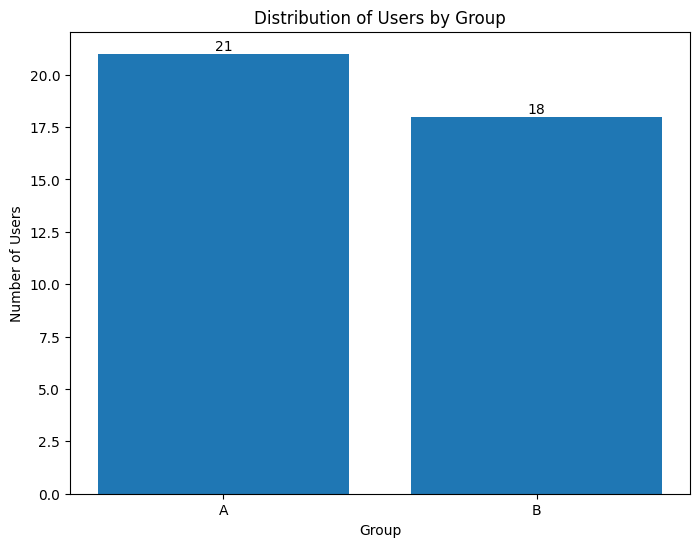

In [65]:
group_counts = users_groups['group'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(group_counts.index, group_counts.values)
plt.title('Distribution of Users by Group')
plt.xlabel('Group')
plt.ylabel('Number of Users')

for i, v in enumerate(group_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

# Remove activity when mode is not valid with experiments settings

In [66]:
df

,user,achievement,points,game_mode,timestamp,group
0,11b1644a-d11f-45cb-8a40-282a209059c0,RefactorAddXAssertionsAchievement,1,Leaderboard,2025-04-17 09:03:37.584413+02:00,A
1,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 09:03:37.608230+02:00,A
2,0d271530-be17-4538-bf04-dde3c6069b5f,AddTestsAchievement,1,Leaderboard,2025-04-17 09:03:49.222756+02:00,A
3,11b1644a-d11f-45cb-8a40-282a209059c0,RefactorAddXAssertionsAchievement,1,Leaderboard,2025-04-17 09:03:58.246131+02:00,A
4,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 09:03:58.276464+02:00,A
...,...,...,...,...,...,...
2504,11b1644a-d11f-45cb-8a40-282a209059c0,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 10:29:54.685880+02:00,A
2505,11b1644a-d11f-45cb-8a40-282a209059c0,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 10:29:56.890680+02:00,A
2506,11b1644a-d11f-45cb-8a40-282a209059c0,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 10:30:03.539677+02:00,A
2507,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 10:42:15.128917+02:00,A


## First session

In [67]:
sessions = get_sessions(df)
groups_first_mode = sessions[((sessions["group"] == "A") & (sessions["game_mode"] == "Achievements")) | ((sessions["group"] == "B") & (sessions["game_mode"] == "Leaderboard"))]

In [68]:
timing_data = []

for index, row in groups_first_mode.iterrows():
    timing_data.append([1, row["group"], row["game_mode"], row["start"], row["theoretical_end"]])
    print(f"Group {row["group"]} - {row["game_mode"]} | session 1 : {row["start"]} -> {row["theoretical_end"]}")

invalid_list = []
for _, row in groups_first_mode.iterrows():
    filtered = df[
        (df["group"] == row["group"]) &
        (df["game_mode"] == row["game_mode"]) &
        ((df["timestamp"] < row["start"]) | (df["timestamp"] > row["theoretical_end"]))
    ]

    invalid_list.append(filtered)

wrong_first_mode = pd.concat(invalid_list, ignore_index=True)
print("Invalid wrong mode activity count :", len(wrong_first_mode))
wrong_first_mode

Group A - Achievements | session 1 : 2025-04-17 09:05:22.951686+02:00 -> 2025-04-17 09:25:22.951686+02:00
Group B - Leaderboard | session 1 : 2025-04-17 09:04:05.435083+02:00 -> 2025-04-17 09:24:05.435083+02:00
Invalid wrong mode activity count : 185


,user,achievement,points,game_mode,timestamp,group
0,a7c1124d-d4fc-4fc7-bb6f-b73e2f1b7fdd,RefactorAddXAssertionsAchievement,2,Achievements,2025-04-17 09:27:53.792802+02:00,A
1,0d271530-be17-4538-bf04-dde3c6069b5f,RunXTestSuitesAchievement,1,Achievements,2025-04-17 09:27:58.790629+02:00,A
2,0d271530-be17-4538-bf04-dde3c6069b5f,RunWithCoverageAchievement,1,Achievements,2025-04-17 09:27:58.805677+02:00,A
3,0d271530-be17-4538-bf04-dde3c6069b5f,RunXTestSuitesAchievement,1,Achievements,2025-04-17 09:31:23.639522+02:00,A
4,0d271530-be17-4538-bf04-dde3c6069b5f,RunXTestSuitesAchievement,1,Achievements,2025-04-17 09:31:37.690236+02:00,A
...,...,...,...,...,...,...
180,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 10:00:45.641312+02:00,B
181,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:57:14.280267+02:00,B
182,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:58:54.760661+02:00,B
183,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:58:59.611324+02:00,B


In [78]:
cleaned_first_part_df = df.merge(wrong_first_mode, how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
cleaned_first_part_df

,user,achievement,points,game_mode,timestamp,group
5,eed81e54-2343-44af-ab2f-cd062db7e11a,AddTestsAchievement,1,Leaderboard,2025-04-17 09:04:05.435083+02:00,B
6,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RefactorAddXAssertionsAchievement,2,Leaderboard,2025-04-17 09:04:05.979055+02:00,B
7,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,AddTestsAchievement,1,Leaderboard,2025-04-17 09:04:05.992210+02:00,B
8,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:04:09.168499+02:00,B
9,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunWithCoverageAchievement,1,Leaderboard,2025-04-17 09:04:09.170740+02:00,B
...,...,...,...,...,...,...
2297,fb270a09-6a45-4eae-8f9a-3c808faec3ee,RefactorCodeAchievement,1,Achievements,2025-04-17 09:58:47.683442+02:00,B
2299,88a83dd8-0ea0-41ad-93ca-d397d796fb37,RunXTestSuitesAchievement,1,Achievements,2025-04-17 09:58:48.304860+02:00,B
2300,88a83dd8-0ea0-41ad-93ca-d397d796fb37,RunWithCoverageAchievement,1,Achievements,2025-04-17 09:58:48.347369+02:00,B
2307,64330b4a-8b12-4c91-9b78-5942c1b9325f,RefactorCodeAchievement,1,Achievements,2025-04-17 09:58:58.104526+02:00,B


In [70]:
sessions = get_sessions(cleaned_first_part_df)

## Get first form submission for second session

In [71]:
forms_data = "../../generated/forms/data.csv"
if not os.path.exists(forms_data):
    raise FileNotFoundError(f"Le fichier {forms_data} n'existe pas. Exécutez le notebook 'notebooks/arrange data/Merge forms data.ipynb' pour le générer.")

form_data_df = pd.read_csv(forms_data, usecols=['Identifiant', 'group', 'Leaderboard Horodateur', 'Achievements Horodateur'])
form_data_df['Leaderboard Horodateur'] = pd.to_datetime(form_data_df['Leaderboard Horodateur'], dayfirst=True)
form_data_df['Achievements Horodateur'] = pd.to_datetime(form_data_df['Achievements Horodateur'], dayfirst=True)

group_a_first_timestamps = form_data_df[form_data_df['group'] == 'A']['Leaderboard Horodateur'].min() - pd.Timedelta(minutes=6)
group_a_first_timestamps = group_a_first_timestamps.tz_localize('Europe/Brussels')
print(f"Group A - leadearboard end time: {group_a_first_timestamps}")

group_b_first_timestamps = form_data_df[form_data_df['group'] == 'B']['Achievements Horodateur'].min() - pd.Timedelta(minutes=6)
group_b_first_timestamps = group_b_first_timestamps.tz_localize('Europe/Brussels')
print(f"Group B - achievements end time: {group_b_first_timestamps}")

Group A - leadearboard end time: 2025-04-17 10:02:54+02:00
Group B - achievements end time: 2025-04-17 09:27:22+02:00


In [79]:
form_data_df[form_data_df['group'] == 'B']

,Identifiant,group,Achievements Horodateur,Leaderboard Horodateur
6,54,B,2025-04-17 09:33:22,2025-04-17 10:09:11
17,32,B,2025-04-17 10:06:54,2025-04-17 09:32:37
18,28,B,2025-04-17 10:07:02,2025-04-17 09:32:56
19,92,B,2025-04-17 10:07:11,2025-04-17 09:32:22
20,104,B,2025-04-17 10:07:20,2025-04-17 09:31:01
21,48,B,2025-04-17 10:07:24,2025-04-17 09:31:50
22,68,B,2025-04-17 10:07:38,2025-04-17 09:30:48
23,36,B,2025-04-17 10:07:39,2025-04-17 09:30:54
24,30,B,2025-04-17 10:07:42,2025-04-17 09:30:54
25,72,B,2025-04-17 10:07:45,2025-04-17 09:31:39


## Second session

In [72]:
sessions = get_sessions(cleaned_first_part_df)
groups_second_mode = (sessions[(
    (sessions["group"] == "A") & (sessions["game_mode"] == "Leaderboard")) |
    ((sessions["group"] == "B") & (sessions["game_mode"] == "Achievements"))
].copy())

groups_second_mode.loc[:, "end"] = groups_second_mode["group"].apply(lambda x: group_a_first_timestamps if x == "A" else group_b_first_timestamps)
groups_second_mode["theoretical_start"] = groups_second_mode["end"] - pd.Timedelta(minutes=20)
groups_second_mode

,group,game_mode,start,theoretical_start,theoretical_end,end
0,A,Leaderboard,2025-04-17 09:03:37.584413+02:00,2025-04-17 09:42:54+02:00,2025-04-17 09:23:37.584413+02:00,2025-04-17 10:02:54+02:00
3,B,Achievements,2025-04-17 09:44:33.184196+02:00,2025-04-17 09:07:22+02:00,2025-04-17 10:04:33.184196+02:00,2025-04-17 09:27:22+02:00


In [73]:
for index, row in groups_second_mode.iterrows():
    timing_data.append([2, row["group"], row["game_mode"], row["theoretical_start"], row["end"]])
    print(f"Group {row["group"]} - {row["game_mode"]} | session 2 : {row["theoretical_start"]} -> {row["end"]}")

filtered_list = []
for _, row in groups_second_mode.iterrows():
    filtered = cleaned_first_part_df[
        (cleaned_first_part_df["group"] == row["group"]) &
        (cleaned_first_part_df["game_mode"] == row["game_mode"]) &
        ((cleaned_first_part_df["timestamp"] < row["theoretical_start"]) | (cleaned_first_part_df["timestamp"] > row["end"]))
    ]

    filtered_list.append(filtered)

wrong_second_mode = pd.concat(filtered_list, ignore_index=True)
print("Invalid wrong mode activity count :", len(wrong_second_mode))
wrong_second_mode[wrong_second_mode['group'] == 'B']

Group A - Leaderboard | session 2 : 2025-04-17 09:42:54+02:00 -> 2025-04-17 10:02:54+02:00
Group B - Achievements | session 2 : 2025-04-17 09:07:22+02:00 -> 2025-04-17 09:27:22+02:00
Invalid wrong mode activity count : 1128


,user,achievement,points,game_mode,timestamp,group
461,f9ec833e-db4f-49b9-9b14-08298cbb4425,RunXTestSuitesAchievement,1,Achievements,2025-04-17 09:45:06.310107+02:00,B
462,70e85b5e-92d4-498a-9079-ba881f5b3b82,RunXTestSuitesAchievement,1,Achievements,2025-04-17 09:45:07.674449+02:00,B
463,64330b4a-8b12-4c91-9b78-5942c1b9325f,RefactorCodeAchievement,1,Achievements,2025-04-17 09:45:54.885904+02:00,B
464,64330b4a-8b12-4c91-9b78-5942c1b9325f,RefactorCodeAchievement,1,Achievements,2025-04-17 09:45:54.890549+02:00,B
465,64330b4a-8b12-4c91-9b78-5942c1b9325f,RefactorCodeAchievement,1,Achievements,2025-04-17 09:45:54.946446+02:00,B
...,...,...,...,...,...,...
1123,fb270a09-6a45-4eae-8f9a-3c808faec3ee,RefactorCodeAchievement,1,Achievements,2025-04-17 09:58:47.683442+02:00,B
1124,88a83dd8-0ea0-41ad-93ca-d397d796fb37,RunXTestSuitesAchievement,1,Achievements,2025-04-17 09:58:48.304860+02:00,B
1125,88a83dd8-0ea0-41ad-93ca-d397d796fb37,RunWithCoverageAchievement,1,Achievements,2025-04-17 09:58:48.347369+02:00,B
1126,64330b4a-8b12-4c91-9b78-5942c1b9325f,RefactorCodeAchievement,1,Achievements,2025-04-17 09:58:58.104526+02:00,B


In [74]:
cleaned_df = cleaned_first_part_df.merge(wrong_second_mode, how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
cleaned_df

,user,achievement,points,game_mode,timestamp,group
5,eed81e54-2343-44af-ab2f-cd062db7e11a,AddTestsAchievement,1,Leaderboard,2025-04-17 09:04:05.435083+02:00,B
6,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RefactorAddXAssertionsAchievement,2,Leaderboard,2025-04-17 09:04:05.979055+02:00,B
7,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,AddTestsAchievement,1,Leaderboard,2025-04-17 09:04:05.992210+02:00,B
8,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:04:09.168499+02:00,B
9,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunWithCoverageAchievement,1,Leaderboard,2025-04-17 09:04:09.170740+02:00,B
...,...,...,...,...,...,...
2123,caadbaac-e919-4b9b-b3a5-9d074d40493c,CoverXBranchesAchievement,4,Leaderboard,2025-04-17 09:58:55.256885+02:00,A
2125,11b1644a-d11f-45cb-8a40-282a209059c0,RefactorAddXAssertionsAchievement,1,Leaderboard,2025-04-17 09:58:59.236919+02:00,A
2126,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 09:58:59.259630+02:00,A
2127,b39dc415-9bb6-4d5d-a8f9-30fd61f6a594,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:58:59.900757+02:00,A


# Save timing dataframe as csv

In [75]:
timing_df = pd.DataFrame(timing_data, columns=["session", "group", "game_mode", "start", "end"])
timing_df['start'] = pd.to_datetime(timing_df['start']).dt.tz_convert('Europe/Brussels').dt.strftime('%Y-%m-%d %H:%M:%S%z')
timing_df['end'] = pd.to_datetime(timing_df['end']).dt.tz_convert('Europe/Brussels').dt.strftime('%Y-%m-%d %H:%M:%S%z')
timing_df.to_csv(f"{out_generated_path}/timing.csv", index=False)

# Outliers

In [76]:
interaction_counts = cleaned_df.groupby(['game_mode', 'group', 'user'])['achievement'].count().reset_index()
interaction_counts[(interaction_counts['game_mode'] == "Achievements") & (interaction_counts['group'] == "B")]

,game_mode,group,user,achievement


In [77]:
outlier_users_by_mode = []

for group in cleaned_df['group'].unique():
    print(f"Groupe {group}")
    for mode in cleaned_df['game_mode'].unique():
        mode_group_counts = interaction_counts.xs((mode, group))

        Q1 = mode_group_counts.quantile(0.25)
        Q3 = mode_group_counts.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        print(f"\t{mode} - Bound: ({lower_bound}, {upper_bound})")

        data = mode_group_counts[(mode_group_counts < lower_bound) | (mode_group_counts > upper_bound)]
        mode_group_outliers = data.index
        print(f"\tOutliers: {data}")
        print("")
        outlier_users_by_mode.extend(mode_group_outliers)


Groupe B


KeyError: ('Leaderboard', 'B')

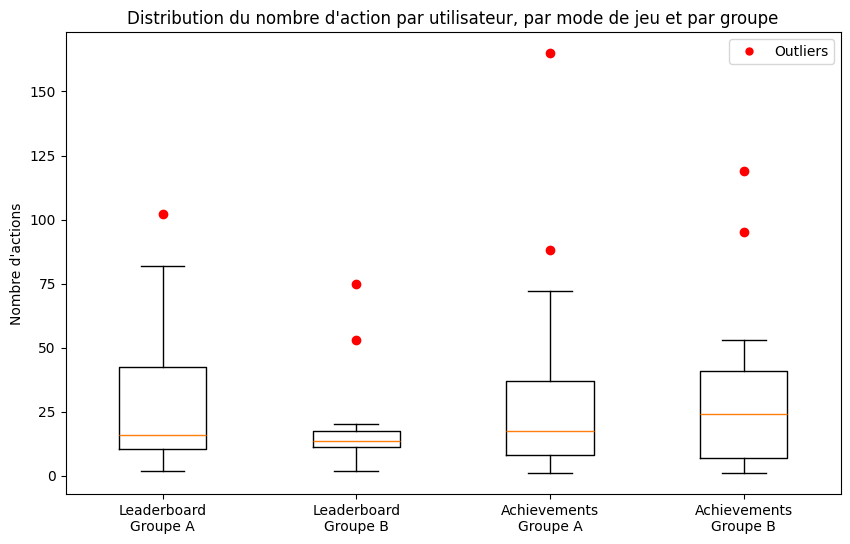

In [57]:
plt.figure(figsize=(10, 6))
color = 'red'

data = []
labels = []

for mode in ['Leaderboard', 'Achievements']:
    for group in ['A', 'B']:
        mode_group_data = cleaned_df[
            (cleaned_df['game_mode'] == mode) &
            (cleaned_df['group'] == group)
            ].groupby('user')['achievement'].count()
        data.append(mode_group_data)
        labels.append(f'{mode}\nGroupe {group}')

plt.boxplot(data, tick_labels=labels, flierprops={'marker': 'o', 'markerfacecolor': color, 'markeredgecolor': color})

plt.title('Distribution du nombre d\'action par utilisateur, par mode de jeu et par groupe avec outliers')
plt.ylabel('Nombre d\'actions')
plt.xticks(rotation=0)

outlier_legend = Line2D([0], [0], marker='o', color='w', label='Outliers',
                        markerfacecolor=color, markeredgecolor=color, markersize=5)
plt.legend(handles=[outlier_legend])

plt.show()


## Final data without outliers

In [58]:
outliers_in_both_modes = list(set([x for x in outlier_users_by_mode if outlier_users_by_mode.count(x) > 1]))
final_df_without_outliners = cleaned_df[~cleaned_df['user'].isin(outliers_in_both_modes)]
final_df_without_outliners

,user,achievement,points,game_mode,timestamp,group
6,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RefactorAddXAssertionsAchievement,2,Leaderboard,2025-04-17 09:04:05.979055+02:00,B
7,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,AddTestsAchievement,1,Leaderboard,2025-04-17 09:04:05.992210+02:00,B
8,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:04:09.168499+02:00,B
9,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunWithCoverageAchievement,1,Leaderboard,2025-04-17 09:04:09.170740+02:00,B
10,d5082901-d846-4794-82af-2c7db8d50788,RefactorCodeAchievement,1,Leaderboard,2025-04-17 09:04:09.754310+02:00,B
...,...,...,...,...,...,...
2125,11b1644a-d11f-45cb-8a40-282a209059c0,RefactorAddXAssertionsAchievement,1,Leaderboard,2025-04-17 09:58:59.236919+02:00,A
2126,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 09:58:59.259630+02:00,A
2127,b39dc415-9bb6-4d5d-a8f9-30fd61f6a594,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:58:59.900757+02:00,A
2128,b39dc415-9bb6-4d5d-a8f9-30fd61f6a594,RunWithCoverageAchievement,1,Leaderboard,2025-04-17 09:58:59.918734+02:00,A


## Outliers stats

In [59]:
df_len = len(cleaned_df)
final_df_len = len(final_df_without_outliners)

print(f"Original dataset size: {df_len}")
print(f"Number of rows removed: {df_len - final_df_len}")
print(f"Dataset size after removing outliers: {final_df_len}")

Original dataset size: 1747
Number of rows removed: 415
Dataset size after removing outliers: 1332


## Save to csv

In [60]:
final_df_without_outliners.to_csv(f"{out_generated_path}/activity.csv", index=False)